In [226]:
#Imports
import pandas as pd
import numpy as np 
import nilearn 
import nibabel as nib
import os
import matplotlib.pyplot as plt

from nilearn import plotting, image
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_design_matrix

#Init variables
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/rabies_test/preprocess'
            
#Data path
subject_path ='/project/4180000.19/multirat_stim/rabies_test/preprocess/sub-0200100_ses-1/bold_datasink/commonspace_bold/_scan_info_subject_id0200100.session1_split_name_sub-0200100_ses-1_T2w/_run_1/sub-0200100_ses-1_run-1_bold_RAS_combined.nii.gz'
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path = '/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'

In [227]:
# Paths for the directories
output_dir = '/project/4180000.19/multirat_stim/rabies_test/first_level_analysis'
matrix_dir = os.path.join(output_dir, 'matrix')
image_dir = os.path.join(output_dir, 'image')


# Create the directories if they don't already exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(matrix_dir):
    os.makedirs(matrix_dir)
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

/tmp/ipykernel_15157/1297028821.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  events_list = events.append(events)
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:74: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn("'trial_type' column not found "


Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


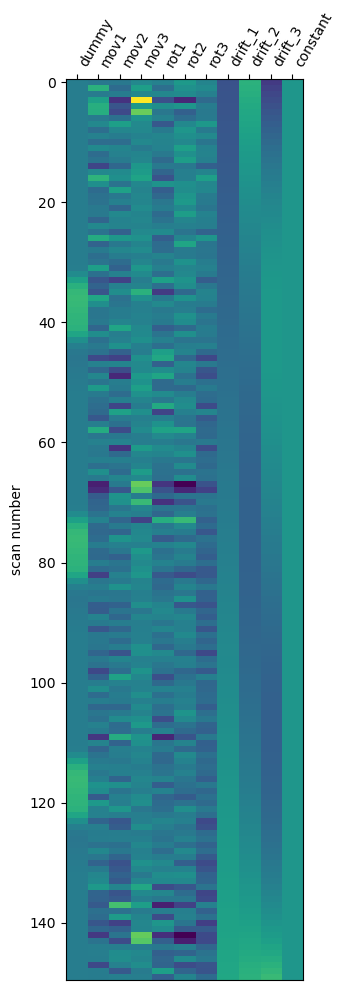

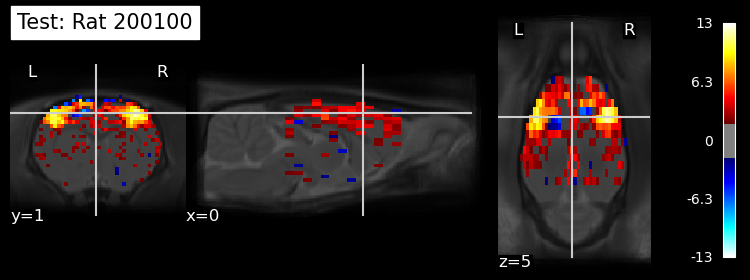

In [230]:
 # ---------- FIRST LEVEL ANALYSIS ------------


for index in range(0, 1):
    
    df = pd.read_csv(metadata_path, sep='\t')
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]

    subject_path = analysis_folder+'/sub-0{}_ses-1/bold_datasink/commonspace_bold/_scan_info_subject_id0{}.session1_split_name_sub-0{}_ses-1_T2w/_run_1/sub-0{}_ses-1_run-1_bold_RAS_combined.nii.gz'.format(subj_num, subj_num, subj_num, subj_num)

    tr=(df.iloc[index]['func.TR'])
    hrf_model = 'spm'
    func_img = nib.load(subject_path)
    header = func_img.header

    dimension = np.array(image.load_img(subject_path).shape)          #put in an array; dimension, number of slices, number of volumes 
    n_scans = dimension[3]                                            #nb volumes
    frame_times = np.arange(n_scans) * tr                             # corresponding frame times


    # --- Events regressor --- 
    
    onset = np.matrix(df.loc[index, 'func.sensory.onset']).A[0]
    duration = np.matrix(df.loc[index,'func.sensory.duration']).A[0]
    events = pd.DataFrame({'onset': onset,'duration': duration})
    events_list = events.append(events)
    
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
    cofounders_path = analysis_folder+'/sub-0{}_ses-1/confounds_datasink/confounds_csv/_scan_info_subject_id0{}.session1_split_name_sub-0{}_ses-1_T2w/_run_1/sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num, subj_num, subj_num, subj_num)

    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    
    # --- Compute design matrix --- 

    design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=motion, 
                                                   add_reg_names=motion_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model=hrf_model, 
                                                   high_pass=0.01)
    plot_design_matrix(design_matrix) 
    #np.savetxt('matrix_sub-0{}_ses-1'.format(subj_num), matrix_dir)
    
    # --- Fitting a first-level model --- 
    
    fmri_glm = FirstLevelModel()
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)
    
    # -- Coompute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map= fmri_glm.compute_contrast(contrast_val, output_type='all')

    plotting.plot_stat_map(statistical_map['z_score'], bg_img = template_path, threshold = 1.9, title = 'Test: Rat 200100')
    #plt.savefig('stat_map_sub-0{}_ses-1'.format(subj_num), image_dir)
